In [13]:
import numpy as np
from kinematics_library import homogeneous as htf
from kinematics_library.homogeneous_utils import get_basis_vectors, get_r_and_R_from_A 
print("Hello world")


Hello world


In [14]:
# Camera 1
cam_1_east = 100  # [m]
cam_1_north = 200  # [m]
cam_1_compass_bearing = np.deg2rad(45) # [deg]

A1n = htf.transx(cam_1_north) @ htf.transy(cam_1_east) @ htf.rotz(cam_1_compass_bearing) # NED
rC1Nn, Rc1n = get_r_and_R_from_A(A1n)
c1_1, c1_2, c1_3 = get_basis_vectors(A1n)


In [15]:
# Camera 2
cam_2_east = 400  # [m]
cam_2_north = 500  # [m]
cam_2_compass_bearing = np.deg2rad(0) # [deg]

A2n = htf.transx(cam_2_north) @ htf.transy(cam_2_east) @ htf.rotz(cam_2_compass_bearing) # NED
rC2Nn, Rc2n = get_r_and_R_from_A(A2n)
c2_1, c2_2, c2_3 = get_basis_vectors(A2n)

In [16]:
# Target track is a line that just passes through world

# Say it starts at some point and just tracks forwards
target_E0 = 1000  # [m]
target_N0 = 0  # [m]
target_alt = 0  # [m]

target_heading = np.deg2rad(0)

target_speed = 300  # [m/s]

ATn = htf.transx(target_N0) @ htf.transy(target_E0) @ htf.transz(-target_alt) @ htf.rotz(target_heading) # NED
rtNn, Rtn = get_r_and_R_from_A(ATn)
t_1, t_2, t_3 = get_basis_vectors(ATn)

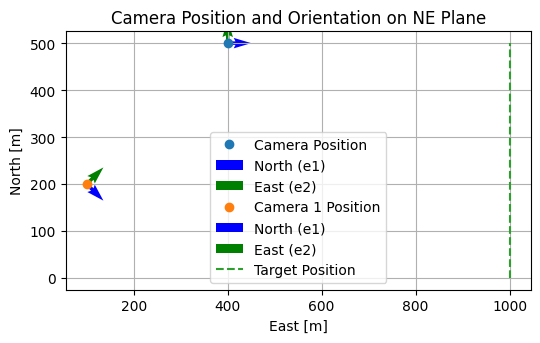

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D plot
fig, ax = plt.subplots(figsize=(6, 6))

# Define the length of the basis vectors for visualization
vector_scale = 0.02  # Adjust as needed


    # Camera 2
ax.plot(rC2Nn[1], rC2Nn[0], 'o', label='Camera Position')

ax.quiver(
    rC2Nn[1], rC2Nn[0],           # Origin of the vector
    c2_2[1], c2_2[0],      # East and North components
    angles='xy',
    scale_units='xy',
    scale=vector_scale,
    color='blue',
    label='North (e1)'
)

ax.quiver(
    rC2Nn[1], rC2Nn[0],
    c2_1[1], c2_1[0],
    angles='xy',
    scale_units='xy',
    scale=vector_scale,
    color='green',
    label='East (e2)'
)

    # Camera 1
ax.plot(rC1Nn[1], rC1Nn[0], 'o', label='Camera 1 Position')

ax.quiver(
    rC1Nn[1], rC1Nn[0],           # Origin of the vector
    c1_2[1], c1_2[0],      # East and North components
    angles='xy',
    scale_units='xy',
    scale=vector_scale,
    color='blue',
    label='North (e1)'
)

ax.quiver(
    rC1Nn[1], rC1Nn[0],
    c1_1[1], c1_1[0],
    angles='xy',
    scale_units='xy',
    scale=vector_scale,
    color='green',
    label='East (e2)'
)

    # Target
ax.plot(1000 * np.ones((100, 1)), np.linspace(0, 500, 100), '--', label='Target Position')

# Set labels and title
ax.set_xlabel('East [m]')
ax.set_ylabel('North [m]')
ax.set_title('Camera Position and Orientation on NE Plane')

# Set equal aspect ratio
ax.set_aspect('equal')

# Add grid and legend
ax.grid(True)
ax.legend()

# Show the plot
plt.show()


In [ ]:
from kinematics_library.homogeneous_utils import get_r_from_A
from numpy.linalg import norm
from dataclasses import dataclass

@dataclass
class CameraDirectionMeasurement:
    base_point: np.ndarray
    dir_vec: np.ndarray


class CameraSensor:
    def __init__(self, E: float, N: float, bearing_deg: float):
        self.Apn = htf.transx(N) @ htf.transy(E) @ htf.rotz(np.deg2rad(bearing_deg))  # NED
        self.false_target_per_timestep = 30

    def get_dir_vec(self, rTNn: np.ndarray) -> np.ndarray:
        rPNn = get_r_from_A(self.Apn)
        dr = rTNn - rPNn
        return dr / norm(dr)

    def get_false_targets(self, N: int):
        false_targets = []
        for _ in range(N):
            A = self.Apn @ htf.roty(np.deg2rad(np.random.uniform(-45, 45))) @ htf.rotz(np.deg2rad(np.random.uniform(-45, 45))) @ htf.transx(10)
            r = get_r_from_A(A)
            false_targets.append(r)
        return false_targets

    def get_detections(self, rTNn) -> list[CameraDirectionMeasurement]:
        measurements = []

        rPNn = get_r_from_A(self.Apn)
        measurements.append(CameraDirectionMeasurement(rPNn, self.get_dir_vec(rTNn)))

        for false_target in self.get_false_targets(self.false_target_per_timestep):
            measurements.append(CameraDirectionMeasurement(rPNn, self.get_dir_vec(false_target)))
        return measurements

c1 = CameraSensor(200, 100, 45)
c1.get_false_targets(10)

[array([[165.92582844],
        [248.03915792],
        [ 57.84483081]]),
 array([[190.44290243],
        [241.90195764],
        [ -8.01918614]]),
 array([[157.09894365],
        [254.86636609],
        [ 61.06875228]]),
 array([[192.52603294],
        [199.35684229],
        [ 37.92782063]]),
 array([[198.15656538],
        [218.48196707],
        [ -4.8688363 ]]),
 array([[180.39841872],
        [248.57729068],
        [ 34.29782933]]),
 array([[196.47800078],
        [218.42731896],
        [ 18.77309992]]),
 array([[111.90270525],
        [293.76225596],
        [-32.66442966]]),
 array([[134.44222161],
        [264.22130761],
        [-68.47888009]]),
 array([[ 91.49583282],
        [285.27047998],
        [-51.54245226]])]